# E4. 작사가 인공지능 만들기
- 순환신경망(RNN)의 LSTM 모델을 활용해서 시작 단어(들) input하면 노래 가사를 output해주는 인공지능을 만듭니다.
- 텐서플로우에서 제공하는 모델을 활용할 것이며, 학습데이터는 영어 노래가사 데이터를 변환한 124981개의 텐서입니다.

**실습목차**

1. 텍스트 데이터 읽어오기
2. 텍스트 데이터 정제하기
3. 작사가 인공지능 만들기   
    3-1) lyricist 모델 만들고 학습하기    
    3-2) lyricist 모델 평가하기
4. 회고


**실습 개요**
- 이번에는 자연어 프로세싱을 연습해볼 수 있는 실습입니다. NLP(Natural Language Processing)의 대표적인 모델로 Recurrent Neural Networks(RNN, 순환신경망)이 있습니다. 관련해서 ratsgo's blog 내용을 인용합니다. RNN은 "히든 노드가 방향을 가진 엣지로 연결돼 순환구조를 이루는(directed cycle) 인공신경망의 한 종류입니다. 음성, 문자 등 순차적으로 등장하는 데이터 처리에 적합한 모델로 알려져 있는데요. ... 길이에 관계없이 인풋과 아웃풋을 받아들일 수 있는 네트워크 구조이기 때문에 필요에 따라 다양하고 유연하게 구조를 만들 수 있다는 점이 RNN의 가장 큰 장점입니다."(https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)
- RNN의 vanishing gradient problem에 대안으로 LSTM 모델을 사용합니다. 위의 ratsgo's blog 글에서 인용하면, "RNN은 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀 경우 역전파시 그래디언트가 점차 줄어 학습능력이 크게 저하되는 것으로 알려져 있습니다. 이를 vanishing gradient problem이라고 합니다. ... LSTM은 RNN의 히든 state에 cell-state를 추가한 구조입니다."
- 실습에서는 RNN의 일종으로 RNN을 보완한 Long Short-Term Memory models(LSTM) 모델을 활용할 것이며, 아래 그림과 같이 4개 레이어(1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어)로 구성을 할 것입니다.

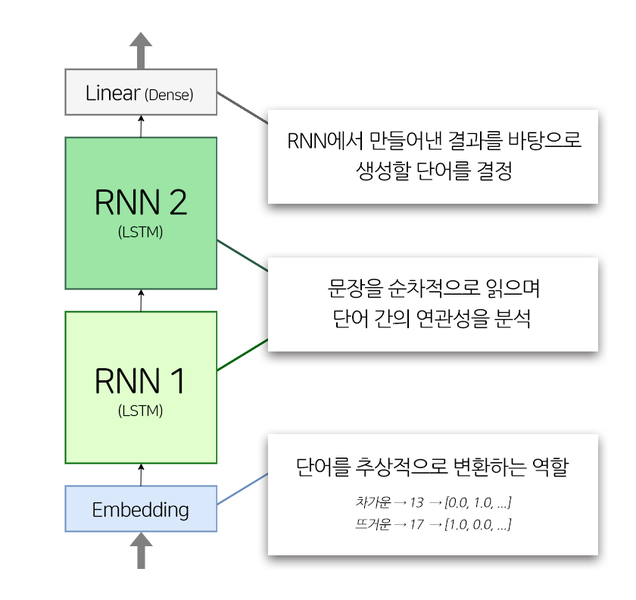

(출처: AIFFEL LMS Exploration 4)   

<br>   
    
**Insight**
- 2020년 중순에 나온 OpenAI의 GPT-3 는 사람이 쓴 것과 비교해도 손색 없을만한 필력으로 기사, 소설, 심지어는 프로그래밍 언어까지 어떤 글감이든 AI가 생성하며 주목을 받았습니다. 또한 GPT-3는 실용성이 높으며, 이전 버전인 GPT-2와 비교하면 알고리즘은 크게 다르지 않지만 학습 규모가 어마어마한 대규모 언어 모델로 평가 받습니다. 이에 대해 MIT Technology Review는 "일례로, GPT-2 신경망의 파라미터는 15억 개였지만 GPT-3 신경망의 파라미터는 1750억 개다. 학습 데이터의 경우도 마찬가지다. 비교 자체가 힘겨운 수준이다." (2021년, MIT Technology Review, https://www.technologyreview.kr/gpt3-best-worst-ai-openai-natural-language/)
- 위 기사는 이렇게 마무리됩니다. "GPT-3는 딥 러닝의 현주소이자, AI의 명암이 모두 담긴 소우주다."
- 이번 실습에서 작문을 하는 딥러닝 모델을 구현해보는 것은 최근 딥러닝 혹은 AI의 현주소를 살펴보는 시작점이라고 생각합니다. 이미 GPT-3를 통해서는 기계와 인간이 자연어로 꽤 원활한 의사소통이 가능해졌습니다. 정리하면, 기계의 자연어 처리는 기계가 사람의 언어를 이해해서 사람과 같이 반응하고 표현하는데 필수적입니다.

## 1. 텍스트 데이터 읽어오기

- 먼저, 영어 노래가사 텍스트 데이터가 담긴 파일들을 읽어올 것입니다.

In [ ]:
# 필요한 모듈을 가져옵니다.
import glob, os, re 
import numpy as np
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# 구글 코랩에서 구글 드라이브 저장위치의 노래가사 텍스트 파일들을 읽어옵니다.
txt_list = glob.glob('drive/MyDrive/Colab Notebooks/lyrics_data/*')

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()    # txt파일을 줄 단위로 끊어서 읽어옵니다.
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))    # raw_corpus에 담겨있는 요소들의 개수를 출력합니다.
print("Examples:\n", raw_corpus[:3])   # raw_corpus 를 앞에서부터 3라인 출력합니다.

데이터 크기: 187088
Examples:
 ["Let's stay together I, I'm I'm so in love with you", 'Whatever you want to do', 'Is all right with me']


## 2. 텍스트 데이터 정제하기

- 텍스트 데이터를 그대로 읽어온 raw한 데이터는 토큰화에 적합하지 않기 때문에 정제해주어야 합니다. 정제할 때에는 정규표현식을 사용해서 텍스트를 원하는 형태로 가공해줍니다.
- 토큰화를 진행하면 12000자의 단어에 대응하는 사전이 생성되고, 이를 활용해 텐서로 변형해서 기계가 이해할 수 있는 텐서가 됩니다.
- 문장의 시작과 끝을 알리는 \<start\> 와 \<end\> 를 넣어줍니다. 훈련 데이터에서 소스 문장(input, \<start\>로 시작)과 타겟문장(\<start\>로 시작하지 않는 output 문장)을 만들어줄 때 필요합니다.

In [ ]:
# 입력된 문장을 정규표현식을 활용해 정제해줍니다.
# 문장부호, 특수문자, 대소문자 등을 필터링하고, 후에 문장을 쪼개서 토큰화해줄 것입니다.
#        1. 소문자로 바꾸고, 양쪽 공백을 지우기
#        2. 특수문자 양쪽에 공백을 넣고
#        3. 여러개의 공백은 하나의 공백으로 바꿉니다
#        4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#        5. 다시 양쪽 공백을 지웁니다
#        6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

In [ ]:
# 정제된 문장을 모아줍니다.
corpus = []

# raw_corpus 의 문장들을 정제해서 corpus 에 담아줍니다.
for sentence in raw_corpus:
    if len(sentence) == 0: continue     # 빈 공백 문장은 건너뜁니다.

    preprocessed_sentence = preprocess_sentence(sentence)
    if len(re.split(r'\s', preprocessed_sentence)) > 15: continue   # 문장에서 토큰 개수가 15개를 넘어가면 건너뜁니다.

    corpus.append(preprocessed_sentence)

corpus[:10]   # corpus 처음 10개를 출력해봅니다.

['<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>',
 '<start> lovin you whether , whether <end>',
 '<start> times are good or bad , happy or sad <end>']

In [ ]:
# 텐서플로 패키지를 사용해서 문장을 토큰화하고, 12,000자 단어사전을 만들어주며, 데이터를 숫자로 변환해 텐서를 반환합니다.
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 12000,
        filters = ' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print("문장 데이터를 텐서로 변환한 결과:\n", tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

문장 데이터를 텐서로 변환한 결과:
 [[   2  570    7 ...    0    0    0]
 [   2   26   25 ...    0    0    0]
 [   2   66    7 ...    0    0    0]
 ...
 [   2   20  149 ...    0    0    0]
 [   2    4   35 ...    3    0    0]
 [   2 1063   10 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f981a027550>


- tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줍니다. 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다.

In [ ]:
# 생성된 토큰을 앞에서부터 10개 출력합니다.
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >= 10 : break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [ ]:
# 만들어진 tensor 에서 랜덤으로 5개 행을 출력해봅니다.
example_tensor = tensor[100:105, :]
print(example_tensor, "\n")

# tokenizer를 이용해 word index를 단어로 하나씩 변환합니다.
for idx, sentence in enumerate(example_tensor):
  print("{}번째 문장:".format(idx+1), end=" ")
  for word_index in sentence:
    if word_index == 0 : continue       # padding 해준 0은 단어장에 들어가있지 않으므로 건너뜁니다.
    print(tokenizer.index_word[word_index], end=" ")
  print("\n")

[[   2   71   11  179    5   71   11  276    5   49    3    0    0    0
     0]
 [   2   71   89 5748    3    0    0    0    0    0    0    0    0    0
     0]
 [   2 2972   28   36    5   71    5 1504    3    0    0    0    0    0
     0]
 [   2 2972   28   36    5 1504    3    0    0    0    0    0    0    0
     0]
 [   2 2972   28   36    3    0    0    0    0    0    0    0    0    0
     0]] 

1번째 문장: <start> say it again , say it together , yeah <end> 

2번째 문장: <start> say wanna moans <end> 

3번째 문장: <start> moan for love , say , hmm <end> 

4번째 문장: <start> moan for love , hmm <end> 

5번째 문장: <start> moan for love <end> 



- 텐서는 "2" \<start\> 토큰으로 시작해서 "3" \<end\> 토큰 또는 "0" padding 토큰으로 끝납니다.

In [ ]:
src_input = tensor[:,:-1]    # 모델의 입력이 되는 소스 문장
tgt_input = tensor[:,1:]     # <start>를 없애준 모델의 출력이 되는 타겟 문장
print("소스문장: ", src_input[0])
print("타겟문장: ", tgt_input[0])    # 소스문장과 비교하면 왼쪽으로 한칸 밀려서 2로 시작하지 않고 570으로 시작합니다.

enc_train, enc_test, dec_train, dec_test = train_test_split(src_input, 
                                                          tgt_input, test_size = 0.2)   # 훈련 데이터, 테스트 데이터 분리

# 훈련 데이터셋을 train dataset, validation set로 분리
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_train, dec_train, test_size=0.2)

소스문장:  [  2 570   7  64  10  48   3   0   0   0   0   0   0   0]
타겟문장:  [570   7  64  10  48   3   0   0   0   0   0   0   0   0]


In [ ]:
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Test: ", enc_val.shape)
print("Target Test: ", dec_val.shape)

Source Train: (99984, 14)
Target Train: (99984, 14)
Source Test:  (24997, 14)
Target Test:  (24997, 14)


## 3. 작사가 인공지능 만들기

- LSTM 모델을 활용해서 작사를 해주는 인공지능을 만들어봅니다.

In [ ]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12,000개와 여기 포함되지 않은 0:<pad>를 포함하여 12,001개
VOCAB_SIZE = tokenizer.num_words + 1

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

### 3-1) lyricist 모델을 만들고 학습하기

In [ ]:
# Embedding, LSTM(1&2), Dense Layer 모델
# 1. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 
# 2,3. LSTM 레이어(1&2)에는 hidden_size(하이퍼파라미터)를 설정해줍니다.
# 4. Dense 레이어

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)   # 1
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)    # 2
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)    # 3 
        self.linear = tf.keras.layers.Dense(vocab_size)    # 4
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
lyricist = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

- 하이퍼파라미터 embedding_size는 256, hidden_size는 1024로 적당히 설정해주었습니다.
- embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기입니다. 크기가 클수록 추상적인 특징을 잘 잡아내지만 그만큼 데이터가 많이 필요합니다.

In [ ]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다.
example_batch_predictions = lyricist(src_sample)
print("예측 결과의 shape:", example_batch_predictions.shape, 
                         "  # (batch_size, sequence_length, vocab_size)")

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
example_batch_loss = loss(tgt_sample, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Mean loss:      ", mean_loss)

print("\nouput tensor:", example_batch_predictions)

예측 결과의 shape: (256, 14, 12001)   # (batch_size, sequence_length, vocab_size)
Mean loss:       9.392846

ouput tensor: tf.Tensor(
[[[ 8.0383579e-05 -4.3557553e-05  2.2186960e-04 ...  2.1383406e-05
   -4.7079182e-05  1.8890500e-04]
  [ 6.5800508e-05  2.2571569e-04  1.1917251e-04 ...  1.3867162e-04
    8.1827180e-05  3.5790063e-04]
  [ 7.8596131e-05  3.2131141e-04  1.2743207e-04 ...  3.4856374e-04
   -3.0831629e-04  4.8316887e-04]
  ...
  [ 3.2415451e-04  8.3502778e-04  4.2148243e-04 ...  3.5800005e-04
    1.0076482e-03  9.3361526e-04]
  [ 1.5233741e-04  7.5354602e-04  5.7086389e-04 ...  3.4807698e-04
    1.1477292e-03  1.1729063e-03]
  [-5.3194558e-06  6.9186650e-04  6.9958670e-04 ...  3.5367141e-04
    1.2737765e-03  1.3727096e-03]]

 [[ 8.0383579e-05 -4.3557553e-05  2.2186960e-04 ...  2.1383406e-05
   -4.7079182e-05  1.8890500e-04]
  [ 4.5844583e-05 -8.8677763e-05  4.3477971e-04 ... -9.6717100e-05
   -1.6854865e-04  2.8176018e-04]
  [-2.6187935e-04 -3.2673054e-04  7.4651168e-04 ... -2.

- output shape에서 256은 배치 사이즈, 14는 시퀀스의 길이(max_len) 그리고 12001은 단어의 개수입니다. 모델의 output은 각 배치에서 각 시퀀스 위치에 들어갈 확률이 높은 단어를 통계적으로 구해줍니다. 즉 12001개의 단어장 길이만큼 계산을 하고, 이것이 시퀀스 길이에 해당하는 만큼 있으며 배치 사이즈 전체에 나타납니다.
- mean loss는 대략 9.39로 나왔습니다. 모델 학습을 통해 loss(손실) 값을 낮춰주는게 필요해보이네요.

In [ ]:
# 모델을 학습시킵니다.
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

lyricist.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
hist = lyricist.fit(dataset, epochs=10, validation_data=(enc_val, dec_val))

Epoch 1/10
390/390 [==============================] - 85s 213ms/step - loss: 3.2390 - accuracy: 0.5052 - val_loss: 3.0274 - val_accuracy: 0.5210
Epoch 2/10
390/390 [==============================] - 87s 224ms/step - loss: 2.8851 - accuracy: 0.5286 - val_loss: 2.8470 - val_accuracy: 0.5335
Epoch 3/10
390/390 [==============================] - 87s 222ms/step - loss: 2.6715 - accuracy: 0.5426 - val_loss: 2.7334 - val_accuracy: 0.5453
Epoch 4/10
390/390 [==============================] - 87s 223ms/step - loss: 2.4916 - accuracy: 0.5572 - val_loss: 2.6523 - val_accuracy: 0.5558
Epoch 5/10
390/390 [==============================] - 87s 222ms/step - loss: 2.3284 - accuracy: 0.5734 - val_loss: 2.5900 - val_accuracy: 0.5663
Epoch 6/10
390/390 [==============================] - 87s 222ms/step - loss: 2.1778 - accuracy: 0.5916 - val_loss: 2.5420 - val_accuracy: 0.5758
Epoch 7/10
390/390 [==============================] - 87s 222ms/step - loss: 2.0393 - accuracy: 0.6109 - val_loss: 2.5048 - val_ac

In [ ]:
lyricist.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


- 작사가 모델 lyricist는 "text_generator" 이며 29,012,961개 파라미터를 가지고 있습니다.

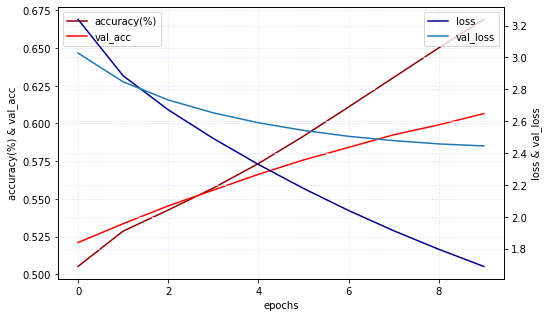

977/977 [==============================] - 15s 15ms/step - loss: 2.4337 - accuracy: 0.6066
(테스트 데이터셋 평가) 
loss : 2.433696746826172, accuracy : 60.6606 %


In [ ]:
import matplotlib.pyplot as plt
epochs = 10
acc = hist.history["accuracy"]
val_acc=hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

fig = plt.figure(figsize=(8,5))
ax_acc = fig.add_subplot(111)
ax_acc.plot(range(epochs), acc, label='accuracy(%)', color='darkred')
ax_acc.plot(val_acc, label="val_acc", color='red')
plt.xlabel('epochs')
plt.ylabel('accuracy(%) & val_acc')
ax_acc.grid(linestyle='--', color='lavender')
plt.legend()

ax_loss = ax_acc.twinx()
ax_loss.plot(range(epochs), loss, label='loss', color='darkblue')
ax_loss.plot(val_loss, label='val_loss')
plt.ylabel('loss & val_loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

plt.legend()
plt.show()

evaluation = lyricist.evaluate(enc_test, dec_test)
print('(테스트 데이터셋 평가)', f'\nloss : {evaluation[0]}, accuracy : {evaluation[1]*100:.6} %')

- 파란선 loss 는 훈련을 하면서 하락하고 있으며 대략 1.7에 가까워졌습니다. 그리고, val_loss는 낮아지고 있지만 loss와 가까워지지는 않고 있습니다. val_loss를 낮추고 싶은데 2.4 정도 수준에서 머무르고 있습니다.
- 빨간선 accuracy 는 훈련을 하면서 증가하고 있습니다만 이 모델의 정확도를 측정하는 것이 어떤 의미를 가지는지 생각해봐야할 것 같습니다. 타겟 문장을 100% 정확하게 맞추는것보다는 다음 단어를 잘 골라주는 모델이기 때문에 LSTM 모델에서는 accuracy 지표가 크게 중요하지는 않다고 생각합니다.
- 훈련한 모델에서 epoch가 진행될수록 파란선 loss 가 낮아지고 있다는 점이 주목할만하며, 노래가사 작문에서 오차가 줄어들고 있다는 점을 시사합니다.
- 테스트 데이터셋을 lyricist 모델로 평가했을 때에 loss가 2.4 수준으로 val_loss와 유사하게 나왔습니다.

### 3-2) lyricist 모델 평가하기

#### 3-2-1) 작문을 해주는 함수를 정의합니다.

In [ ]:
# 학습이 된 모델에게 작문을 시켜봅니다.
# 시작문장을 전달하면 작문을 해줍니다. 
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

아래 그림은 tensorflow 홈페이지에서 가져온 것으로, text generator 모델이 문장을 만드는 과정을 보여줍니다.     

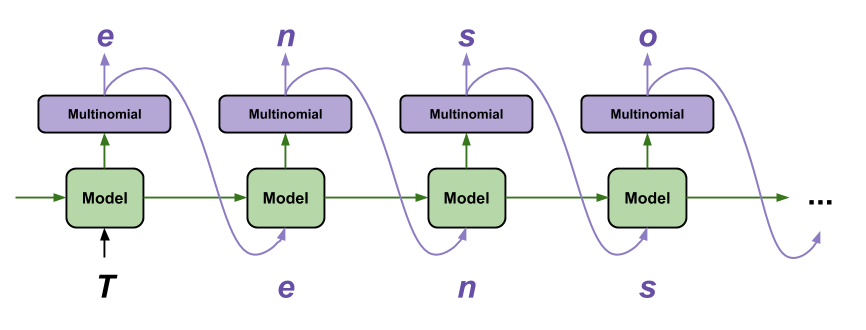
출처: https://www.tensorflow.org/text/tutorials/text_generation


#### 3-2-2) Lyricist 모델 평가: 다양한 시작문장을 주고 가사를 작문해보기
- 꽤 그럴듯한 가사가 나왔네요! 중간중간 나쁜말도 있는데 학습한 노래 가사에 많이 등장했나보군요.

In [ ]:
# 10줄 노래 만들기
l_1 = generate_text(lyricist, tokenizer, init_sentence="<start> i love")
l_2 = generate_text(lyricist, tokenizer, init_sentence="<start> i miss")
l_3 = generate_text(lyricist, tokenizer, init_sentence="<start> i think")
l_4 = generate_text(lyricist, tokenizer, init_sentence="<start> you are")
l_5 = generate_text(lyricist, tokenizer, init_sentence="<start> it is")
l_6 = generate_text(lyricist, tokenizer, init_sentence="<start> oh")
l_7 = generate_text(lyricist, tokenizer, init_sentence="<start> yo")
l_8 = generate_text(lyricist, tokenizer, init_sentence="<start> i m")
l_9 = generate_text(lyricist, tokenizer, init_sentence="<start> what")
l_10 = generate_text(lyricist, tokenizer, init_sentence="<start> but")
print("title: AI written song\n", l_1, l_2, l_3, l_4, l_5, l_6, l_7, l_8, l_9, l_10, sep="\n")

title: AI written song

<start> i love you baby , i love u so much <end> 
<start> i miss you <end> 
<start> i think i m ready for the future i am <end> 
<start> you are the one that i adore you <end> 
<start> it is a woken dream <end> 
<start> oh , oh , oh , oh , oh , oh <end> 
<start> yo , i m just goin in my mind <end> 
<start> i m a superwoman of a <unk> <end> 
<start> what you want be what you want <end> 
<start> but i m not a love for love <end> 


In [ ]:
# 테스트 데이터의 source 문장 10개를 input으로 주고 target 문장과 비교해봅니다.
# target 문장 처음 10개를 리스트에 저장합니다.
list_target=[]
for idx, sentence in enumerate(dec_test):
  if idx >= 10: continue
  target_sentence=""
  for word_index in sentence:
    if word_index == 0 : continue    
    target_sentence += tokenizer.index_word[word_index] + " "
  list_target.append(target_sentence)

for idx, sentence in enumerate(enc_test):
  if idx >= 10: continue
  init_sentence = ""

  for i, word_index in enumerate(sentence):
    if i >=2 : continue
    init_sentence += tokenizer.index_word[word_index] + " "
  print("작사가 모델의 가사:", generate_text(lyricist, tokenizer, init_sentence))
  print("target 문장:    ", list_target[idx], "\n")

작사가 모델의 가사: <start> some people live for the power , yeah <end> 
target 문장:     some things don t change the girls roll up <end>  

작사가 모델의 가사: <start> i m a superwoman of a <unk> <end> 
target 문장:     i m a get a scholarship to king s college <end>  

작사가 모델의 가사: <start> there s a sign in the window <end> 
target 문장:     there s a creak beneath the floor <end>  

작사가 모델의 가사: <start> i m a superwoman of a <unk> <end> 
target 문장:     i left hungover ? <end>  

작사가 모델의 가사: <start> zat a match <end> 
target 문장:     zat a guarantee of freedom for our descendants ? <end>  

작사가 모델의 가사: <start> whats up with the <unk> <end> 
target 문장:     whats drugs my dealer whats that jacket <unk> <end>  

작사가 모델의 가사: <start> i m a superwoman of a <unk> <end> 
target 문장:     i ve been searching everywhere and now here you are ooh , chunky <end>  

작사가 모델의 가사: <start> they ll never catch me <end> 
target 문장:     they like the way i ball they call me hot sauce <end>  

작사가 모델의 가사: <start> enough to cop six

## 4. 회고
**\<lyricist 모델 평가에 대한 회고\>**
- 작사가 모델은 테스트 데이터셋과 분리된 훈련 데이터셋을 바탕으로 작문을 해주기 때문에 작사한 내용이 테스트 데이터셋의 target 문장과는 거의 다릅니다. 그럼에도, 작사가 모델은 꽤나 말이 되는 가사를 생성해줬습니다.
- 하지만 타겟문장과 비교해보면 작사가 모델의 창의성은 다소 떨어지는 것 같습니다. 훈련받은 데이터에서 높은 확률로 등장한 단어들을 생성하기 때문에 자주 등장하는 단어들이 있는 것 같습니다. 예를 들면, "\<start\> i m a superwoman of a \<unk\> \<end\> " 이 문장을 노래 가사로 두번 생성해줬습니다. text generator 모델이 훈련받은 데이터셋 텍스트에 영향을 받는다는 것을 확인 할 수 있었고, 인터넷에 있는 텍스트들을 많이 활용한다면 인터넷 용어들이 많이 등장하는 것 같이 데이터셋의 bias가 개입될 수 있습니다.
- 또한 작사가 모델은 단어장에 포함되지 않은 단어들은 \<unk\> 로 출력하고 있어서, 더 많은 언어 다양성을 담고 있지 못합니다.

<br>

**\<총평\>**
- 작사가 모델이 문장을 생성할 수 있는 것은 많은 문장 데이터(시퀀스)를 학습한 결과이며, 입력받은 단어 다음에 올 단어를 계속 순환적으로 구해주는 알고리즘의 덕분입니다.(RNN)
- 자연어 처리 중 텍스트를 다룰 때 중요한 것은 텍스트를 전처리하는 것입니다. 실습에서도 텍스트 데이터를 가져와서 먼저 정규표현식을 활용해서 원하는 형태로 텍스트를 가공해주었습니다. 그리고 이후에 텐서플로우의 tf.keras.preprocessing.text.Tokenizer 를 활용해 토큰화와 텐서로 변형을 진행해주었습니다. 토큰화라는 것이 재미있는 개념인데, 예를 들면 텍스트 데이터를 공백을 기준으로 나눠서 각 단어나 문장부호 등을 숫자에 대응시켜 사전처럼 사용하는 것입니다. 기계는 사람의 언어를 이해하지 못하므로 기계의 언어로 바꿔주는 과정입니다. 모델학습 단계에서는 사람이 알기 쉬운 문장이 아닌, 텐서를 가지고 학습을 하게 됩니다.
- 작사가 모델이 만들어준 노랫말을 확인해보니 그럴 듯한 노래 구절이어서 놀라웠습니다.
- 자연어 처리를 해보면서 흥미로웠고, 관련해서 더 공부해보고 싶다는 생각이 들었습니다. 또한 작사가 모델은 학습데이터로 외국가수들의 노래가사를 훈련했는데, 우리나라 노래 가사를 훈련하면 어떤 작사를 해줄지 궁금했습니다.